In [119]:
!pip install nlp

In [120]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()


print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.12.0


## Task 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [121]:
pip install -U datasets

In [122]:
import datasets

In [123]:
from datasets import load_dataset
dataset = load_dataset("emotion")

In [124]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [125]:
train = dataset['train']
val = dataset['validation']
test= dataset['test']

In [126]:
def get_tweet(data):
  tweets= [x['text'] for x in data]
  labels = [x['label'] for x in data]
  return tweets, labels

In [127]:
tweets, labels = get_tweet(train)

In [128]:
tweets[0], labels[0]

('i didnt feel humiliated', 0)

In [129]:
tweets[1], labels [1]

('i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 0)

## Task 4: Tokenizer

1. Tokenizing the tweets

In [130]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [131]:
tokenizer = Tokenizer(num_words=10000, oov_token ='<UNK>')
tokenizer.fit_on_texts(tweets)

In [132]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

In [133]:
tweets[0]

'i didnt feel humiliated'

## Task 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

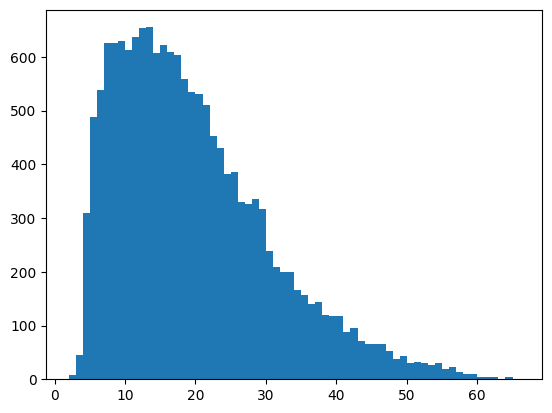

In [134]:
lengths =[len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins = len(set(lengths)))
plt.show()

In [135]:
maxlen=50
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [136]:
def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating='post', padding='post',maxlen=maxlen)
  return padded

In [137]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [138]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## Task 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [139]:
classes = set(labels)
classes

{0, 1, 2, 3, 4, 5}

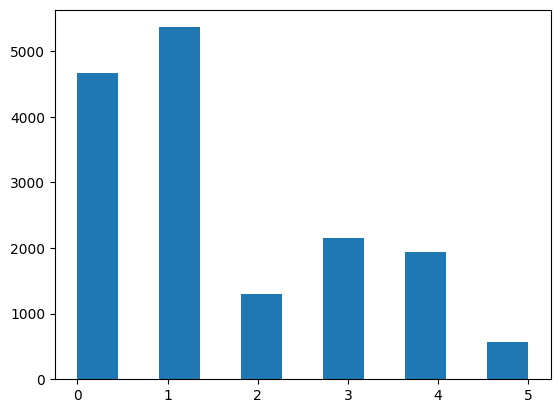

In [140]:
plt.hist(labels,bins=11)
plt.show()

In [141]:
class_to_index = dict((c,i)for i, c in enumerate(classes))
index_to_class= dict((v, k) for k, v in class_to_index.items())

In [142]:
class_to_index

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}

https://www.kaggle.com/datasets/parulpandey/emotion-dataset
go here for values lol
a classification label, with possible values including sadness (0), joy (1), love (2), anger (3), fear (4).

In [143]:
names_to_ids =lambda labels: np.array([class_to_index.get(x) for x in labels])

In [144]:
train_labels =names_to_ids(labels)
train_labels[0]

0

a classification label, with possible values including sadness (0), joy (1), love (2), anger (3), fear (4).

that whole section was kinda redundant but I learnt something

## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

In [145]:
model= tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [146]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 16)            160000    
                                                                 
 bidirectional_4 (Bidirectio  (None, 50, 40)           5920      
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


k 8: Training the Model

1. Preparing a validation set
2. Training the model

In [147]:
val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels= names_to_ids(val_labels)

In [148]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 0)

In [149]:
h= model.fit(
    padded_train_seq, train_labels,
    validation_data=(val_seq, val_labels),
    epochs = 20,
    callbacks= [
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
    ]
)

Epoch 1/20
500/500 [==============================] - 46s 68ms/step - loss: 1.2952 - accuracy: 0.5031 - val_loss: 0.8361 - val_accuracy: 0.7020
Epoch 2/20
500/500 [==============================] - 10s 20ms/step - loss: 0.6329 - accuracy: 0.7770 - val_loss: 0.5776 - val_accuracy: 0.8070
Epoch 3/20
500/500 [==============================] - 9s 18ms/step - loss: 0.3359 - accuracy: 0.8919 - val_loss: 0.4327 - val_accuracy: 0.8650
Epoch 4/20
500/500 [==============================] - 7s 15ms/step - loss: 0.2043 - accuracy: 0.9362 - val_loss: 0.4162 - val_accuracy: 0.8715
Epoch 5/20
500/500 [==============================] - 8s 17ms/step - loss: 0.1598 - accuracy: 0.9507 - val_loss: 0.3998 - val_accuracy: 0.8835
Epoch 6/20
500/500 [==============================] - 8s 15ms/step - loss: 0.1105 - accuracy: 0.9658 - val_loss: 0.3979 - val_accuracy: 0.8850
Epoch 7/20
500/500 [==============================] - 8s 15ms/step - loss: 0.0898 - accuracy: 0.9723 - val_loss: 0.3949 - val_accuracy: 0.88

## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

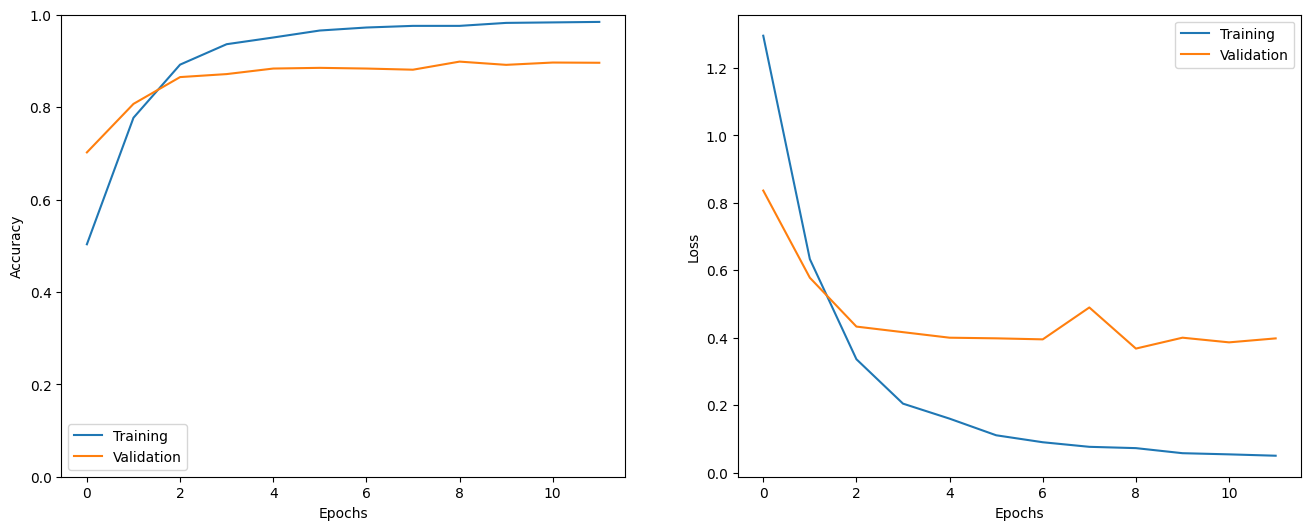

In [150]:
show_history(h)

In [151]:
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels =names_to_ids(test_labels) #ik ik

In [152]:

test_labels

array([0, 0, 0, ..., 1, 1, 4])

In [153]:
_ = model.evaluate( test_seq, test_labels)

63/63 [==============================] - 0s 7ms/step - loss: 0.3908 - accuracy: 0.8940


In [154]:
i = random.randint(0,len(test_labels)-1)
print("String: ",test_tweets[i])
print("Expected class: ",test_labels[i])

p = model.predict(np.expand_dims(test_seq[i], axis= 0),verbose=0) [0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]


print("Predicted class: ",pred_class)
print("Key: sadness (0), joy (1), love (2), anger (3), fear (4)")

String:  i love a hearty chat where i mean everything that i say and laugh from the heart gut w e not because i wanna let the person feel im entertained
Expected class:  1
Predicted class:  1
Key: sadness (0), joy (1), love (2), anger (3), fear (4)


In [183]:
preds = model.predict(test_seq)


63/63 [==============================] - 0s 7ms/step


In [184]:

preds = np.argmax(preds,axis=1)


In [175]:
preds

array([0, 0, 0, ..., 1, 1, 5])

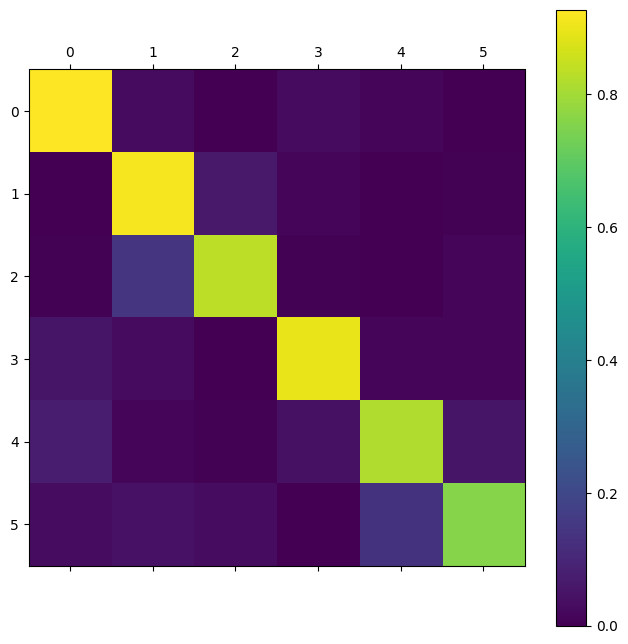

In [185]:

show_confusion_matrix(test_labels, preds,classes)
